In [407]:
import requests
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
from keras.layers import Input, Dense
from keras.models import Model
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

In [550]:
gen1_dir = "./sprites/GenI"
gen2_dir = "./sprites/GenII"
gen3_dir = "./sprites/GenIII"
gen4_dir = "./sprites/GenIV"
gen5_dir = "./sprites/GenV"

In [551]:
def get_images_at(path):
    excluded = ['GenIA.png', 'GenIB.png', '.DS_Store', 'GenIIA.png', 'GenIIB.png',
               'CastformRain.png', 'CastformSnowy.png', 'CastformSunny.png', 'GenIIIA.png', 'GenIIIB.png',
               'GenIVA.png', 'GenIVB.png', 'GenVA.png', 'GenVB.png']
    images = os.listdir(path)
    return [os.path.join(path, u) for u in images if u not in excluded]

In [552]:
all_images = []
all_images += get_images_at(gen1_dir)
all_images += get_images_at(gen2_dir)
all_images += get_images_at(gen3_dir)
all_images += get_images_at(gen4_dir)
all_images += get_images_at(gen5_dir)

image_paths = np.array(all_images)

dataset = np.ndarray(shape=(len(image_paths), 64, 64, 3), dtype=np.uint8)

i = 0
for path in image_paths:
    pil_im = Image.open(path, 'r')
    img_arr = np.asarray(pil_im)
    trimmed = img_arr[0:64, 0:64, :3]
    dataset[i] = trimmed
    i += 1

print(dataset.shape)

(709, 64, 64, 3)


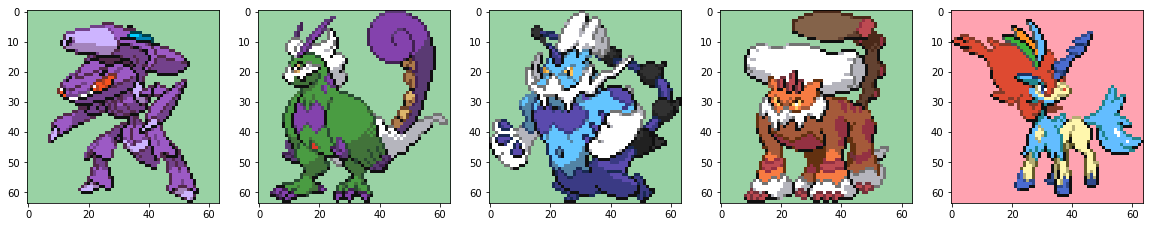

In [553]:
plt.figure(figsize=(20,10))
columns = 5
imgs = dataset[-5:]
for i, image in enumerate(imgs):
    plt.subplot(len(imgs) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [582]:
# print(dataset.shape)

size = len(dataset)
bottom = int(size * .8)

poke_train = dataset[:bottom]
poke_test = dataset[bottom:]

poke_train = poke_train.astype(np.float32) / 255.
poke_test = poke_test.astype(np.float32) / 255.
poke_train = poke_train.reshape((len(poke_train), np.prod(poke_train.shape[1:])))
poke_test = poke_test.reshape((len(poke_test), np.prod(poke_test.shape[1:])))

print(poke_train.shape)
# print(poke_train[:5])
print(poke_test.shape)
# print(poke_test[:5])




(567, 12288)
(142, 12288)


In [555]:
#target size of rep
encoding_dim = 32

#input
input_img = Input(shape=(12288,))

# encoded rep of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# reconstruction of the input
decoded = Dense(12288, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [602]:
encoded_dim = 32
input_img = Input(shape=(12288,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(12288, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

#### Encoder

In [600]:
encoder = Model(input_img, encoded)

#### Decoder

In [594]:
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

Configure the model

In [603]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [401]:
# from keras.datasets import mnist
# import numpy as np
# (x_train, _), (x_test, _) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# print(x_train.shape)
# print(x_test.shape)

(60000, 784)
(10000, 784)


In [604]:
autoencoder.fit(poke_train, poke_train, \
                epochs=100, \
                batch_size=128, \
                shuffle=True, \
                validation_data=(poke_test, poke_test))

Train on 567 samples, validate on 142 samples
Epoch 1/100
567/567 [==============================] - 2s 4ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 8/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 9/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 10/100
567/567 [=======================

Epoch 81/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6463 - val_loss: 0.6528
Epoch 82/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6462 - val_loss: 0.6527
Epoch 83/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6462 - val_loss: 0.6530
Epoch 84/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6462 - val_loss: 0.6527
Epoch 85/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6462 - val_loss: 0.6527
Epoch 86/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6462 - val_loss: 0.6528
Epoch 87/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6461 - val_loss: 0.6527
Epoch 88/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6461 - val_loss: 0.6527
Epoch 89/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6461 - val_loss: 0.6527
Epoch 90/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6461

In [605]:
# encoded_imgs = encoder.predict(poke_test)
decoded_imgs = autoencoder.predict(poke_test)

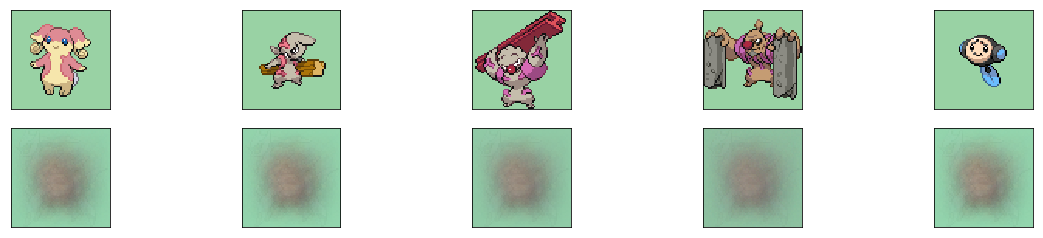

In [607]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(poke_test[i].reshape(64, 64, 3))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()